In [ ]:
# ===============================================================
# Gape Phase 4 – Minimal Evaluation Notebook
# Focus:
#   - Latency: median, |median|, perfect onset rate
#   - Feeding pattern: F1, bout recall
#   - Simple bootstrap 95% CIs across sessions
#   - Input: TWO CSVs → GT + Pred
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# ---------------------------------------------------------------
# 1. Helper: find contiguous 1-segments (bouts)
#    - Used to convert a binary feeding vector (0/1 per frame)
#      into a list of "bouts" (continuous stretches of feeding = 1).
# ---------------------------------------------------------------

def find_segments(binary_seq):
    """
    Input: 1D array of 0/1.
    Output: list of (start_idx, end_idx) for each contiguous block of 1s.
    end_idx is exclusive.
    """
    # Ensure numpy int array
    seq = np.asarray(binary_seq).astype(int)
    segments = []
    in_seg = False
    start = 0

    # Walk through frames and detect when a block of 1s starts and ends
    for i, v in enumerate(seq):
        if v == 1 and not in_seg:
            in_seg = True
            start = i
        elif v == 0 and in_seg:
            segments.append((start, i))
            in_seg = False

    # If we ended inside a segment, close it at the end
    if in_seg:
        segments.append((start, len(seq)))

    return segments

# ---------------------------------------------------------------
# 2. Per-session latency (CORE metrics only)
#    - Takes true & predicted gape onset times for ONE session.
#    - Computes:
#        * n_cycles            : number of onsets
#        * median_latency      : median(pred - true)
#        * median_abs_latency  : median(|pred - true|)
#        * perfect_onset_rate  : fraction within tolerance
# ---------------------------------------------------------------

def evaluate_latency_per_session(true_onsets, pred_onsets, perfect_tolerance):
    """
    true_onsets, pred_onsets: 1D arrays of onset times (same length).
    perfect_tolerance: abs latency <= this is counted as 'perfect' (same units).
    Returns ONLY the core metrics needed.
    """
    true_onsets = np.asarray(true_onsets, dtype=float).ravel()
    pred_onsets = np.asarray(pred_onsets, dtype=float).ravel()

    # Safety check: both arrays must match in length
    if true_onsets.shape != pred_onsets.shape:
        raise ValueError("true_onsets and pred_onsets must have same length")

    # If there are no cycles, return NaNs
    if true_onsets.size == 0:
        return {
            "n_cycles": 0,
            "median_latency": np.nan,
            "median_abs_latency": np.nan,
            "perfect_onset_rate": np.nan,
        }

    # Signed latency: positive = model is late, negative = early
    lat = pred_onsets - true_onsets
    # Absolute latency: size of timing error
    abs_lat = np.abs(lat)

    # Median signed latency (robust to outliers)
    median_latency = float(np.median(lat))
    # Median absolute latency (typical magnitude of error)
    median_abs_latency = float(np.median(abs_lat))
    # Fraction of cycles counted as "perfect" according to tolerance
    perfect_onset_rate = float(np.mean(abs_lat <= perfect_tolerance))

    return {
        "n_cycles": int(lat.size),
        "median_latency": median_latency,
        "median_abs_latency": median_abs_latency,
        "perfect_onset_rate": perfect_onset_rate,
    }

# ---------------------------------------------------------------
# 3. Per-session feeding (CORE metrics only)
#    - Takes feeding GT & predicted 0/1 vectors for ONE session.
#    - Computes:
#        * n_frames   : number of timepoints
#        * f1_feeding : frame-wise F1-score
#        * bout_recall: fraction of true bouts overlapped by any prediction
# ---------------------------------------------------------------

def evaluate_feeding_per_session(gt_feeding, pred_feeding):
    """
    gt_feeding, pred_feeding: 1D arrays of 0/1 (same length).
    Returns only:
      - f1_feeding (frame-wise)
      - bout_recall (how many true bouts overlapped by any prediction)
    """
    gt = np.asarray(gt_feeding).ravel().astype(int)
    pred = np.asarray(pred_feeding).ravel().astype(int)

    # Safety check: both sequences must be same length
    if gt.shape != pred.shape:
        raise ValueError("gt_feeding and pred_feeding must have same length")

    # If there are no frames, return NaNs
    if gt.size == 0:
        return {
            "n_frames": 0,
            "f1_feeding": np.nan,
            "bout_recall": np.nan,
        }

    # frame-wise TP/FP/FN for "feeding = 1"
    tp = float(np.sum((gt == 1) & (pred == 1)))
    fp = float(np.sum((gt == 0) & (pred == 1)))
    fn = float(np.sum((gt == 1) & (pred == 0)))

    # Standard precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    recall = tp / (tp + fn) if (tp + fn) > 0 else np.nan

    # F1-score combines precision + recall
    if np.isnan(precision) or np.isnan(recall) or (precision + recall) == 0:
        f1 = np.nan
    else:
        f1 = 2 * precision * recall / (precision + recall)

    # Bout-level recall:
    #   - Find all true feeding bouts (contiguous 1s in GT)
    #   - Check what fraction overlap with ANY predicted feeding bout
    true_segments = find_segments(gt)
    pred_segments = find_segments(pred)
    n_true_bouts = len(true_segments)

    if n_true_bouts > 0:
        detected = 0
        for ts, te in true_segments:
            # Overlap if the segments share at least one frame
            overlaps = any(not (pe <= ts or ps >= te) for ps, pe in pred_segments)
            if overlaps:
                detected += 1
        bout_recall = detected / n_true_bouts
    else:
        bout_recall = np.nan

    return {
        "n_frames": int(gt.size),
        "f1_feeding": float(f1) if not np.isnan(f1) else np.nan,
        "bout_recall": float(bout_recall) if not np.isnan(bout_recall) else np.nan,
    }

# ---------------------------------------------------------------
# 4. Simple bootstrap CI helper
#    - Takes a metric across sessions (Series) and returns:
#        * mean
#        * ci_low
#        * ci_high
#      using bootstrap resampling.
# ---------------------------------------------------------------

def bootstrap_ci(series, n_bootstrap=1000, ci=0.95, random_state=0):
    """
    Bootstrap CI for the mean of a metric across sessions.
    series: pandas Series (one value per session).
    Returns: (mean, ci_low, ci_high)
    """
    vals = series.dropna().to_numpy(dtype=float)
    if vals.size == 0:
        return (np.nan, np.nan, np.nan)
    if vals.size == 1:
        m = float(vals[0])
        return (m, np.nan, np.nan)  # CI not meaningful with 1 session

    rng = np.random.default_rng(random_state)
    boot_means = np.empty(n_bootstrap, dtype=float)
    n = vals.size

    # Resample sessions with replacement and compute mean each time
    for b in range(n_bootstrap):
        sample = rng.choice(vals, size=n, replace=True)
        boot_means[b] = sample.mean()

    # Mean of original values
    m = float(np.mean(vals))
    # Percentile-based CI
    alpha = 1.0 - ci
    low = float(np.percentile(boot_means, 100 * (alpha / 2.0)))
    high = float(np.percentile(boot_means, 100 * (1.0 - alpha / 2.0)))
    return m, low, high

# ---------------------------------------------------------------
# 5. Main evaluation over sessions
#    - Input: `sessions` list (one dict per session).
#    - For each session:
#        * compute latency metrics
#        * compute feeding metrics
#    - Returns:
#        * per_session_df: one row per session with core metrics
#        * summary_df    : mean ± 95% CI across sessions
# ---------------------------------------------------------------

def evaluate_gape_phase4(
    sessions,
    perfect_latency_tolerance,
):
    """
    sessions: list of dicts, each like:
        {
          "session_id": "monkey01_day1",
          "true_onsets": 1D array,
          "pred_onsets": 1D array,
          "gt_feeding": 1D array (0/1),
          "pred_feeding": 1D array (0/1),
        }

    Returns:
        per_session_df : per-session core metrics (DataFrame)
        summary_df     : mean + 95% CI across sessions for each core metric
    """
    rows = []

    # Loop over all sessions and compute metrics
    for sess in sessions:
        sid = sess["session_id"]

        # Latency metrics for this session
        lat = evaluate_latency_per_session(
            sess["true_onsets"],
            sess["pred_onsets"],
            perfect_tolerance=perfect_latency_tolerance,
        )
        # Feeding metrics for this session
        feed = evaluate_feeding_per_session(
            sess["gt_feeding"],
            sess["pred_feeding"],
        )

        # Merge all core metrics into one row
        row = {
            "session_id": sid,
            "n_cycles": lat["n_cycles"],
            "median_latency": lat["median_latency"],
            "median_abs_latency": lat["median_abs_latency"],
            "perfect_onset_rate": lat["perfect_onset_rate"],
            "n_frames": feed["n_frames"],
            "f1_feeding": feed["f1_feeding"],
            "bout_recall": feed["bout_recall"],
        }
        rows.append(row)

    # Build per-session DataFrame
    per_session_df = pd.DataFrame(rows).set_index("session_id")

    # Build summary with mean + 95% bootstrap CI per core metric
    summary_rows = []
    for col in ["median_latency", "median_abs_latency",
                "perfect_onset_rate", "f1_feeding", "bout_recall"]:
        mean, ci_low, ci_high = bootstrap_ci(per_session_df[col])
        summary_rows.append({
            "metric": col,
            "mean": mean,
            "ci_low": ci_low,
            "ci_high": ci_high,
        })
    summary_df = pd.DataFrame(summary_rows).set_index("metric")

    return per_session_df, summary_df

# ---------------------------------------------------------------
# 6. Build `sessions` from TWO CSVs: GT + Pred
#    - This is the only I/O piece.
#    - User just provides:
#         * gt_csv_path
#         * pred_csv_path
#      with the required columns.
# ---------------------------------------------------------------

def build_sessions_from_csv(gt_csv_path, pred_csv_path):
    """
    Expects two CSVs with columns:

      Ground truth CSV (gt_csv_path):
        - session_id
        - frame
        - feeding_gt   (0/1)
        - onset_gt     (0/1; 1 only at true onset frames)

      Prediction CSV (pred_csv_path):
        - session_id
        - frame
        - feeding_pred (0/1)
        - onset_pred   (0/1; 1 only at predicted onset frames)

    Returns:
      sessions list compatible with evaluate_gape_phase4()
    """
    # Read both CSVs
    gt = pd.read_csv(gt_csv_path)
    pred = pd.read_csv(pred_csv_path)

    sessions = []

    # Loop over each unique session_id in GT
    for sid in gt["session_id"].unique():
        # Sort by frame to ensure alignment
        gt_s = gt[gt["session_id"] == sid].sort_values("frame")
        pred_s = pred[pred["session_id"] == sid].sort_values("frame")

        # basic checks: same number of frames and same frame indices
        if len(gt_s) != len(pred_s):
            raise ValueError(f"Frame count mismatch for session {sid}")
        if not np.all(gt_s["frame"].values == pred_s["frame"].values):
            raise ValueError(f"Frame alignment mismatch for session {sid}")

        # feeding sequences (0/1 per frame)
        gt_feeding = gt_s["feeding_gt"].to_numpy().astype(int)
        pred_feeding = pred_s["feeding_pred"].to_numpy().astype(int)

        # onset times = frames where onset flag == 1
        true_onsets = gt_s.loc[gt_s["onset_gt"] == 1, "frame"].to_numpy()
        pred_onsets = pred_s.loc[pred_s["onset_pred"] == 1, "frame"].to_numpy()

        # We require same number of onsets in GT and prediction
        if len(true_onsets) != len(pred_onsets):
            raise ValueError(
                f"Onset count mismatch in session {sid}: "
                f"{len(true_onsets)} GT vs {len(pred_onsets)} Pred"
            )

        # Append one session dict in the format expected by evaluate_gape_phase4
        sessions.append({
            "session_id": sid,
            "true_onsets": true_onsets,
            "pred_onsets": pred_onsets,
            "gt_feeding": gt_feeding,
            "pred_feeding": pred_feeding,
        })

    return sessions

# ---------------------------------------------------------------
# 7. RUN EVALUATION (edit only paths + tolerance)
#    - This is the user-facing part:
#        1) Set paths to CSVs
#        2) Build sessions
#        3) Set perfect_tol
#        4) Run evaluate_gape_phase4
#        5) Inspect tables + plot
# ---------------------------------------------------------------

# 1) Set your CSV paths here
gt_csv_path = "gt.csv"       # ground-truth CSV
pred_csv_path = "pred.csv"   # prediction CSV

# 2) Build sessions from those two CSVs
sessions = build_sessions_from_csv(gt_csv_path, pred_csv_path)

# 3) Choose what "perfect onset" means
#    Example: 1.0 frame at 60 Hz → within ±1 frame counts as perfect.
perfect_tol = 1.0  # e.g. ±1 frame at 60 Hz

# 4) Run evaluation
per_session_df, summary_df = evaluate_gape_phase4(
    sessions,
    perfect_latency_tolerance=perfect_tol,
)

# Print per-session table
print("=== Core metrics per session ===")
display(per_session_df)

# Print across-session summary (mean ± 95% CI)
print("\n=== Mean ± 95% CI across sessions (core metrics) ===")
display(summary_df)

# 5) Optional quick plot: median latency per session
plt.figure(figsize=(6, 4))
per_session_df["median_latency"].plot(kind="bar")
plt.axhline(0, linestyle="--", linewidth=1)
plt.ylabel("Median latency (pred - true)")
plt.title("Median gape onset latency per session")
plt.tight_layout()
plt.show()


# Example: How to Read the Phase 4 Gape & Feeding Metrics

When you run the notebook, you get **two tables** and **one plot** like this example.

---

## 1. Per-session metrics (what happened in each recording)

Example output:

| session_id     | n_cycles | median_latency | median_abs_latency | perfect_onset_rate | n_frames | f1_feeding | bout_recall |
|----------------|----------|----------------|--------------------|--------------------|----------|-----------|------------|
| monkey01_day1  | 30       | 2.10           | 2.10               | 0.10               | 1000     | 0.786      | 0.918      |
| monkey01_day2  | 30       | 1.73           | 1.73               | 0.30               | 1000     | 0.779      | 0.918      |
| monkey02_day1  | 30       | 1.77           | 1.77               | 0.20               | 1000     | 0.800      | 0.903      |

Assume data are at **60 Hz** (1 frame ≈ 16.7 ms).

### 1.1 Latency metrics

- **`median_latency`** (pred − true, in frames)  
  - monkey01_day1: **2.10 frames late**  
  - monkey01_day2: **1.73 frames late**  
  - monkey02_day1: **1.77 frames late**

  Clinically:  
  - 2 frames at 60 Hz ≈ **33 ms**.  
  - So this model is consistently **~30–35 ms late** in calling gape onset.  
  - It is *biased but consistent*: it tends to be late by a similar amount in all sessions.

- **`median_abs_latency`**  
  - Here it is the same as `median_latency`, which tells us the latency is mostly on one side (always late, not sometimes early and sometimes late).  
  - Interpretation: typical timing error size is also ~2 frames (≈33 ms).

- **`perfect_onset_rate`** (within ±1 frame of truth)  
  - monkey01_day1: **0.10 → 10%** of gapes are within ±1 frame  
  - monkey01_day2: **0.30 → 30%** within ±1 frame  
  - monkey02_day1: **0.20 → 20%** within ±1 frame  

  Clinically:  
  - If ±1 frame = ±16.7 ms is your “clinically perfect” window, then only **10–30%** of onsets are that tight.  
  - The **majority** of onsets are still close (≈2 frames off), but not inside the strict “perfect” window.  
  - This is a detector that is **usable but not razor-sharp** in time: it systematically lags by ~30 ms and is “exact” only in a subset of cycles.

### 1.2 Feeding pattern metrics

- **`f1_feeding`** (frame-wise F1-score for feeding vs non-feeding)  
  - monkey01_day1: **0.79**  
  - monkey01_day2: **0.78**  
  - monkey02_day1: **0.80**

  Interpretation in plain language:  
  - F1 of ~0.78–0.80 means the model is doing a **good but not perfect** job at labeling frames as feeding vs not feeding.  
  - It balances:
    - **Precision** – when the model says “feeding”, it is usually correct.  
    - **Recall** – when the animal is truly feeding, the model usually marks it.  
  - In practice, ~0.8 feels like: *“most feeding frames are caught and most non-feeding frames are left alone, but you will still see some misses and some spurious feeding labels.”*

- **`bout_recall`** (did we hit each real feeding episode at least once?)  
  - monkey01_day1: **0.918**  
  - monkey01_day2: **0.918**  
  - monkey02_day1: **0.903**

  Clinically:  
  - **>0.9** means that **over 90% of real feeding bouts** have at least some overlap with a predicted feeding bout.  
  - So even if the **frame-by-frame labels are imperfect**, the model almost always detects that “a feeding episode happened here”.  
  - This is important if a clinician mainly cares about *“how many feeding episodes did this animal have?”* rather than the exact start/stop frame of every bout.

---

## 2. Across-session summary (how stable the model is)

Example summary table:

| metric              | mean    | ci_low   | ci_high  |
|---------------------|---------|----------|----------|
| median_latency      | 1.87    | 1.73     | 2.10     |
| median_abs_latency  | 1.87    | 1.73     | 2.10     |
| perfect_onset_rate  | 0.20    | 0.10     | 0.30     |
| f1_feeding          | 0.79    | 0.78     | 0.80     |
| bout_recall         | 0.91    | 0.90     | 0.92     |

The **mean** is the average over all sessions; the **CI** (confidence interval) shows how much this metric varies across sessions.

### 2.1 Latency summary

- **`median_latency` mean ≈ 1.87 frames (CI: 1.73–2.10)**  
  - On average, across animals and days, the detector is **about 1.9 frames late**, i.e. ~**32 ms late at 60 Hz**.  
  - The CI is narrow (1.7–2.1), so this delay is **quite consistent across sessions**.  
  - Clinically: if a constant ~30 ms delay is acceptable—or if you can systematically correct for it—this model is predictable and stable.

- **`median_abs_latency`** has exactly the same numbers  
  - This confirms what we saw before: the error is mostly **one-sided (late)** rather than being sometimes early, sometimes late.

- **`perfect_onset_rate` mean = 0.20 (CI: 0.10–0.30)**  
  - Across all sessions, about **20% of gapes** are detected within the strict ±1 frame window.  
  - The CI says that in a new session, you should expect somewhere between **10% and 30%** of onsets to be “perfectly” timed.  
  - Clinically: if you require a very tight temporal precision (e.g., for closed-loop stimulation tied to exact gape onset), this might be **borderline** and you may want either:
    - a looser definition of “perfect”, or  
    - a better detector.

### 2.2 Feeding summary

- **`f1_feeding` mean ≈ 0.79 (CI: ~0.78–0.80)**  
  - The model’s frame-wise feeding classification is **consistently high** (around 0.79) and **doesn’t vary much** between sessions.  
  - CI is very narrow: you can expect similar performance on other days/animals in similar conditions.  
  - Clinically: for “how many frames is the animal feeding vs not feeding?”, this detector is **reliable and stable**.

- **`bout_recall` mean ≈ 0.91 (CI: 0.90–0.92)**  
  - On average, the model **hits about 91% of all real feeding bouts** at least once.  
  - With such a tight CI, this bout-level detection is **very stable across sessions**.  
  - Clinically: if the question is “did a feeding episode occur?” rather than exact timing per frame, this detector is **very dependable**.

---

## 3. The bar plot: median latency per session

The plot:

> **Median gape onset latency per session**  
> (bar of `median_latency` for each session)

What it tells you:

- All three bars are between **~1.7 and ~2.1 frames**.  
- They are all **above zero**, so the model is systematically **late** in calling gape onset.  
- There are **no extreme outliers**: all three sessions show similar behavior.

Clinically, this matches the idea of a detector that:

- is **biased late by ~30 ms**,  
- but is **consistent across days and animals**,  
- which is often easier to work with than a detector that is sometimes early, sometimes late, and highly variable.

---

## 4. One-sentence clinical summary for this example

> This model detects gape onsets with a **stable ~30 ms delay** and “perfect” timing in about **20% of cycles**, while its feeding classifier shows **good frame-wise agreement (F1 ~0.8)** and **very high bout detection (~90% of episodes found)** across sessions.

You can reuse this style of interpretation whenever you run the notebook with real data from new models.


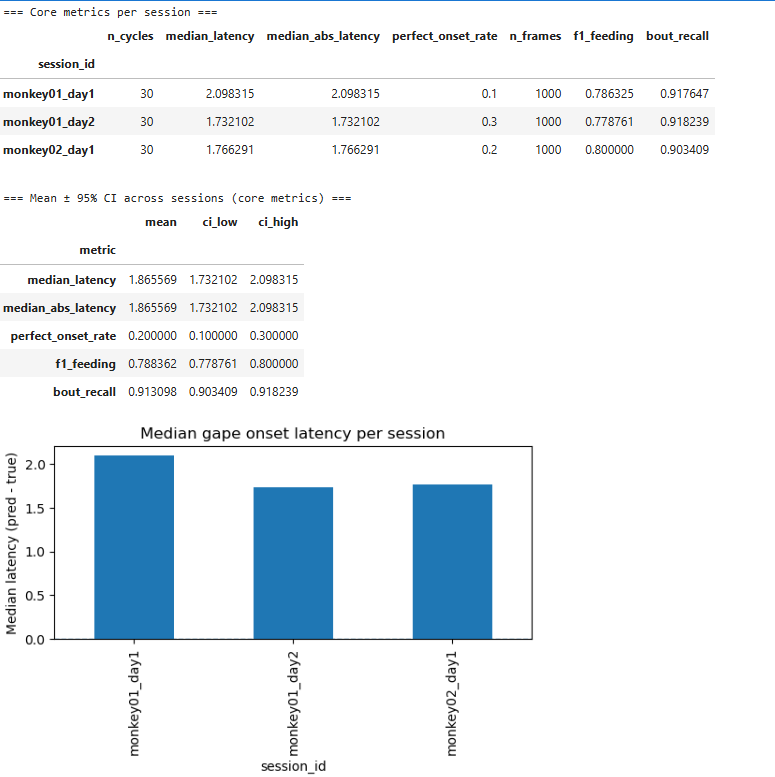

In [9]:
from IPython.display import Image
# Display an image from a local file
Image(filename='../results/gape_result.png')